# Project: Road Accidents in France based on Annual Road Traffic Accident Injury Database (2005 - 2023)

## Step 2: Final data cleaning and feature engineering

Import required libraries and load the cleaned dataset containing accident records

In [53]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Standard libraries
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & feature engineering
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import TruncatedSVD
from scipy.stats import chi2_contingency

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Imbalanced data handling
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks


In [55]:
file_path = "../data/processed/accidents_cleaned.csv"
df = pd.read_csv(file_path, low_memory=False)

### Data Cleaning, Type Adjustment and Categorical Data Sanitization
Convert relevant columns to appropriate data types:
- Categorical for classification features
- Integer type for age and nbv

Ensure all categorical columns contain only string-like values by:
- Converting to string
- Filling missing values with "unknown"
- Casting to category type for compatibility with encoders

In [57]:
pd.set_option('display.max_columns', None)
print(df.head())

        num_acc  lum  agg  int  atm  col  catr  circ  nbv  vosp  prof  plan  \
0  200500000001  3.0  2.0  1.0  1.0  3.0   3.0   2.0  2.0   0.0   1.0   1.0   
1  200500000001  3.0  2.0  1.0  1.0  3.0   3.0   2.0  2.0   0.0   1.0   1.0   
2  200500000001  3.0  2.0  1.0  1.0  3.0   3.0   2.0  2.0   0.0   1.0   1.0   
3  200500000001  3.0  2.0  1.0  1.0  3.0   3.0   2.0  2.0   0.0   1.0   1.0   
4  200500000001  3.0  2.0  1.0  1.0  3.0   3.0   2.0  2.0   0.0   1.0   1.0   

   surf  infra  situ  senc  catv  obs  obsm  choc  manv  place  catu  grav  \
0   1.0    0.0   1.0   0.0   7.0  0.0   2.0   1.0   1.0    1.0   1.0   4.0   
1   1.0    0.0   1.0   0.0   7.0  0.0   2.0   1.0   1.0    1.0   1.0   3.0   
2   1.0    0.0   1.0   0.0   7.0  0.0   2.0   1.0   1.0    2.0   2.0   1.0   
3   1.0    0.0   1.0   0.0   7.0  0.0   2.0   1.0   1.0    4.0   2.0   1.0   
4   1.0    0.0   1.0   0.0   7.0  0.0   2.0   1.0   1.0    5.0   2.0   1.0   

   sexe  trajet  hrmn_clean             datetime  hour  

In [58]:
# Drop unwanted due to high NaN percentage or redundant columns 
df.drop(columns=[
    'num_acc', 'hrmn_clean', 'insee_code', 'lat_clean', 'long_clean', 'manv', 'trajet'
], inplace=True, errors='ignore')

# Fill NaNs in 'belt_status' with -1 (treat as "not specified")
df['belt_status'] = df['belt_status'].fillna(-1)

# Drop any remaining rows with NaNs
df.dropna(inplace=True)

In [59]:
# Define and clean categorical columns
categorical_columns = [
    "lum", "agg", "int", "atm", "col", "catr", "circ", "vosp", "prof", "plan",
    "surf", "infra", "situ", "senc", "catv", "obs", "obsm", "choc",
    "place", "catu", "grav", "sexe", "belt_status", "dayofweek"
]

for col in categorical_columns:
    if col in df.columns:
        # If float, convert to Int64 (nullable), then string
        if pd.api.types.is_float_dtype(df[col]):
            df[col] = df[col].astype("Int64")
        # Now convert to string and then category
        df[col] = df[col].astype(str).fillna("unknown").astype("category")

# Convert 'age' and 'nbv' to nullable integer type
df["age"] = df["age"].astype("Int64")
df["nbv"] = df["nbv"].astype("Int64")

# Final check
print(df.dtypes)
print(df.head())

lum            category
agg            category
int            category
atm            category
col            category
catr           category
circ           category
nbv               Int64
vosp           category
prof           category
plan           category
surf           category
infra          category
situ           category
senc           category
catv           category
obs            category
obsm           category
choc           category
place          category
catu           category
grav           category
sexe           category
datetime         object
hour              int64
dayofweek      category
belt_status    category
age               Int64
dtype: object
  lum agg int atm col catr circ  nbv vosp prof plan surf infra situ senc catv  \
0   3   2   1   1   3    3    2    2    0    1    1    1     0    1    0    7   
1   3   2   1   1   3    3    2    2    0    1    1    1     0    1    0    7   
2   3   2   1   1   3    3    2    2    0    1    1    1     0    1    

### Dimensionality Reduction for Categorical Features using Cramér’s V

To assess redundancy and correlation between categorical features, we calculated pairwise **Cramér's V** values, a metric for association strength between categorical variables (ranging from 0 to 1).
We implemented a custom function to compute Cramér’s V based on the chi-squared statistic from contingency tables. This enabled pairwise correlation measurement across all categorical columns

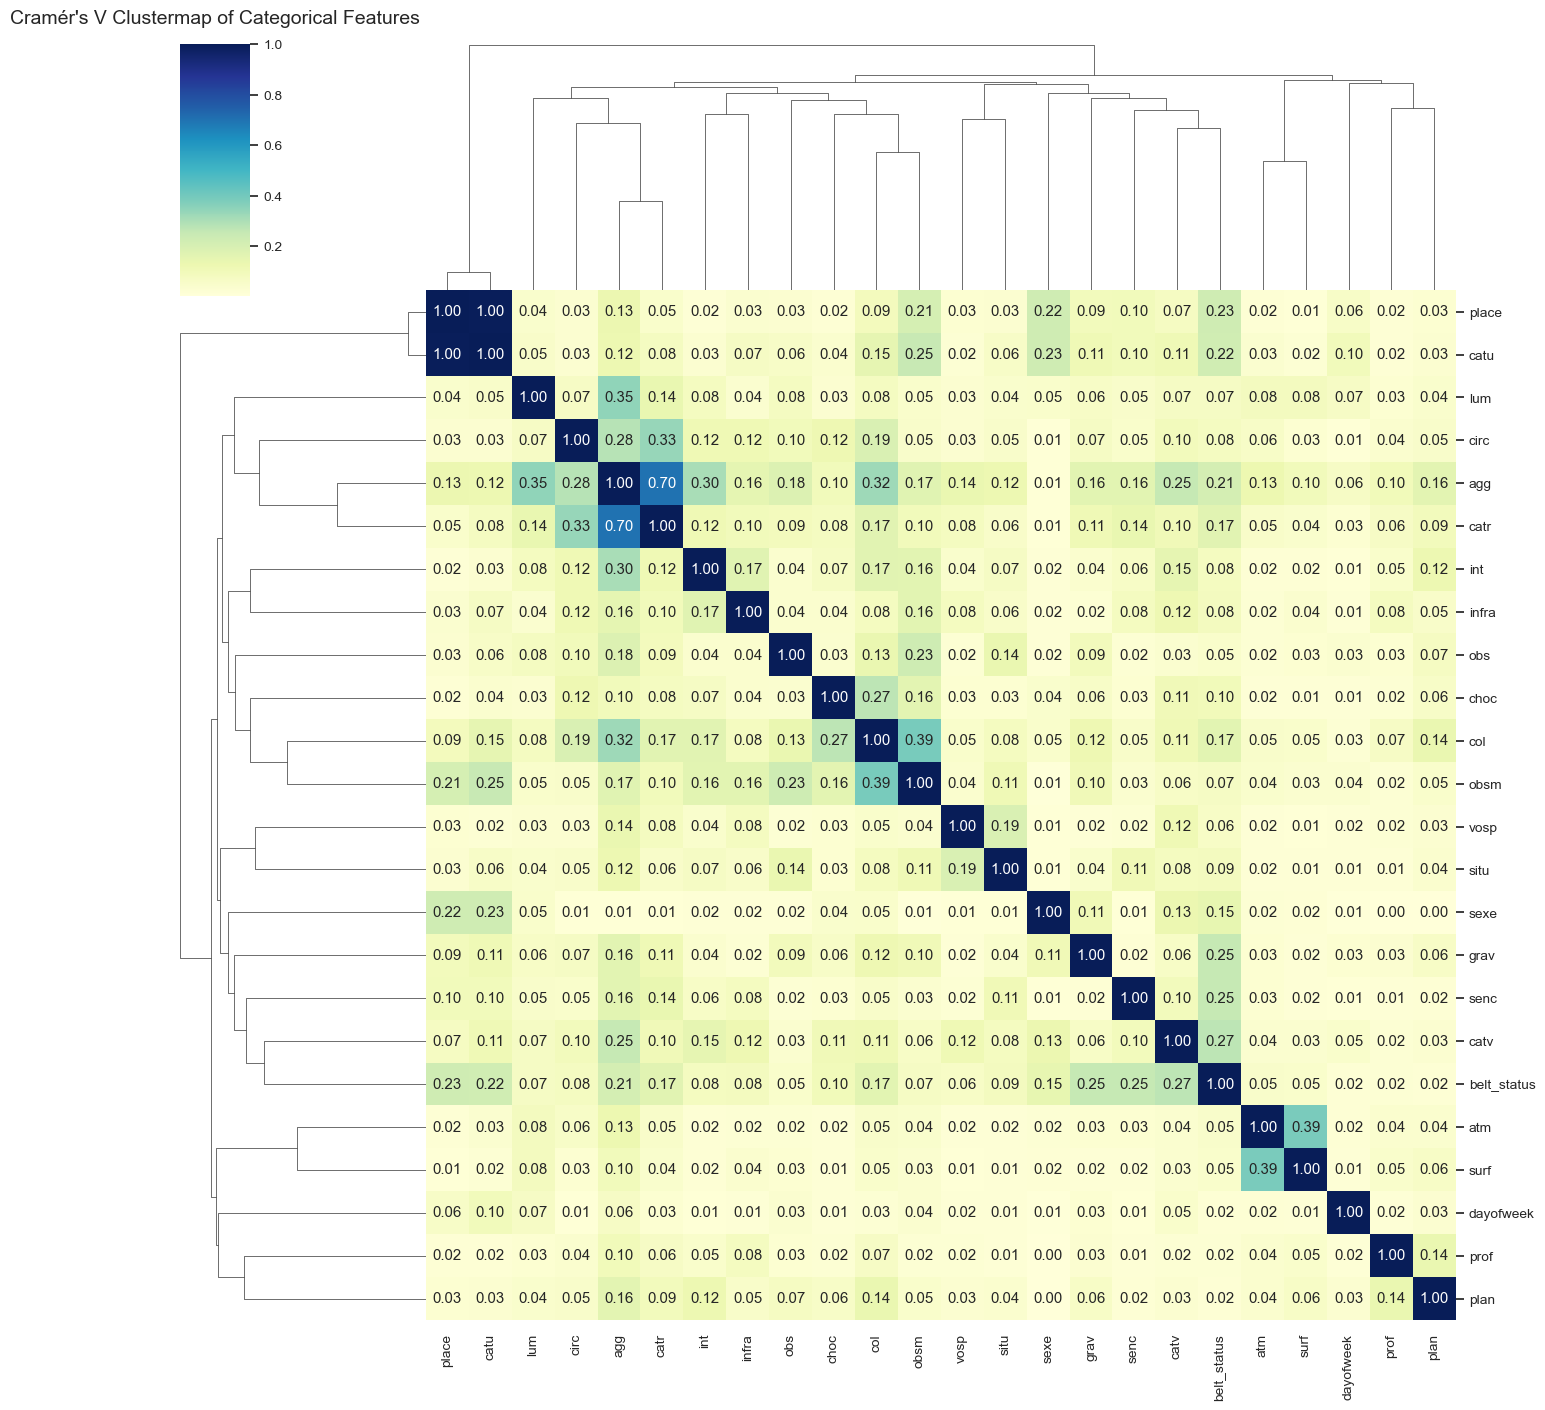

In [61]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

def cramers_v_matrix(df):
    categorical_cols = df.select_dtypes(include=['category']).columns
    matrix = pd.DataFrame(np.zeros((len(categorical_cols), len(categorical_cols))),
                          index=categorical_cols, columns=categorical_cols)

    for col1 in categorical_cols:
        for col2 in categorical_cols:
            if col1 == col2:
                matrix.loc[col1, col2] = 1.0
            else:
                confusion_matrix = pd.crosstab(df[col1], df[col2])
                matrix.loc[col1, col2] = cramers_v(confusion_matrix)
    return matrix

cramers_matrix = cramers_v_matrix(df)

# Plotting the heatmap
sns.set(font_scale=0.9)

sns.clustermap(
    cramers_matrix,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    figsize=(14, 14)
)

plt.title("Cramér's V Clustermap of Categorical Features", fontsize=14, pad=15)
plt.show()


#### Redundancy Check: `place` vs `catu`

The Cramér’s V value between `place` and `catu` is **1**, indicating a **very strong association**. This reflects their structural relationship:
  - `catu = 3` (Pedestrian) always maps to `place = 10`.
  - `catu = 1 or 2` (Driver/Passenger) corresponds to specific seat positions (`place` 1–9).
These features are **highly redundant** and encode overlapping information.

We analyzed the relationship between `place` (seat/location) and `grav` (injury severity) using a column-normalized heatmap and found that `place = 1.0` dominates across all severity levels, contributing **76–88%** of cases. Other values are rare and provide minimal differentiation.

The `place` variable exhibits low informational value and high redundancy. It has been **dropped** from the dataset to reduce noise and simplify the feature set.

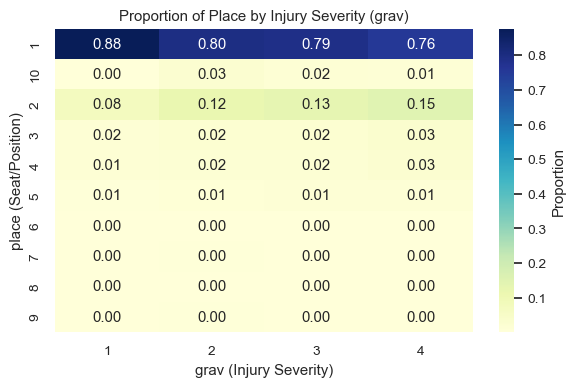

In [63]:
place_grav_ct = pd.crosstab(df['place'], df['grav'])
place_grav_colnorm = place_grav_ct.div(place_grav_ct.sum(axis=0), axis=1)

plt.figure(figsize=(6, 4))
sns.heatmap(place_grav_colnorm, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Proportion'})
plt.title('Proportion of Place by Injury Severity (grav)')
plt.xlabel('grav (Injury Severity)')
plt.ylabel('place (Seat/Position)')
plt.tight_layout()
plt.show()

#### Redundancy Analysis: `agg` and `catr`
Cramér’s V reveals strong associations:
  - `agg` ↔ `catr`: **0.70**
    
These features reflect overlapping spatial and infrastructure information: urban areas are tied to specific road types.

`agg` and `catr` were combined into a single feature `agg_catr` to preserve geographic and infrastructure context while reducing dimensionality.


In [65]:
df['agg_catr'] = df['agg'].astype(str) + "_" + df['catr'].astype(str)
df['agg_catr'] = df['agg_catr'].astype('category')
# Check Distribution
print(df['agg_catr'].value_counts())

agg_catr
2_4    2640516
1_3     760628
2_3     751718
1_1     676004
1_2     275618
2_2     187155
1_4     111645
2_9      44207
2_7      26286
1_9      10311
1_7       9976
2_1       7246
2_6       6280
2_5       3161
1_5       1524
1_6       1428
Name: count, dtype: int64


### Dimensionality Reduction: `catv` (Vehicle Category)

The original `catv` column contains over 40 vehicle types, including several deprecated or rarely used codes. To reduce dimensionality and improve model performance, we regrouped the codes into semantically meaningful clusters:

| Group ID | Category                      | Codes Included                                  |
|----------|-------------------------------|--------------------------------------------------|
| 1        | Micromobility & Cycles        | 01, 30–36, 50, 60, 80                            |
| 2        | Light Vehicles                | 07, 10                                           |
| 3        | Trucks & Tractors             | 13–17                                            |
| 4        | Public Transport              | 37, 38                                           |
| 5        | Special / Agricultural / Other| 20, 21, 99                                       |
| 6        | Rail-based                    | 39, 40                                           |
| 7        | Three-Wheelers                | 41–43                                            |
| 8        | Deprecated / Unused           | 00, 02–06, 08–09, 11–12, 18–19                   |
| 9        | Unmapped / Unknown            | Anything not listed above                       |


This grouping reduces the cardinality of `catv` while preserving critical distinctions that could impact injury severity prediction.

In [67]:
df['catv'] = df['catv'].astype(int)

# Define groups
group_definitions = {
    1: [1, 30, 31, 32, 33, 34, 35, 36, 50, 60, 80],  # Micromobility & Cycles
    2: [7, 10],  # Light Vehicles
    3: [13, 14, 15, 16, 17],  # Trucks & Tractors
    4: [37, 38],  # Public Transport
    5: [20, 21, 99],  # Special / Agricultural / Other
    6: [39, 40],  # Rail-based
    7: [41, 42, 43],  # Three-Wheelers
    8: [0, 2, 3, 4, 5, 6, 8, 9, 11, 12, 18, 19],  # Deprecated / Unused
}

code_to_group = {code: group for group, codes in group_definitions.items() for code in codes}
df['catv_group'] = df['catv'].map(code_to_group).fillna(9).astype(int)

# See distribution
print(df['catv_group'].value_counts().sort_index())

catv_group
1     953094
2    3937281
3     169427
4      54659
5      31729
6       9127
7       5348
8     353038
Name: count, dtype: int64


### Feature Engineering


rush_hour: Peak traffic time indicator
Peak hours: 7–9 AM (7–8), 4–7 PM (16–18)

season: Based on month, winter 1, spring 2, summer 3, autumn 4

age_bins: Age groups
Useful for modeling behavior risk by age group. 1: '<18', 2: '18-25', 3: '26-40', 4: '41-60', 5: '60+'

combine user_type and belt_status into a new feature — for example, to distinguish between:
Driver wearing a belt
Passenger not wearing a belt
Pedestrian (for whom belt use is irrelevant)


In [70]:
df['rush_hour'] = df['hour'].apply(lambda h: 1 if h in [7, 8, 16, 17, 18] else 0)
print(df['rush_hour'].value_counts().sort_index())

rush_hour
0    3515190
1    1998513
Name: count, dtype: int64


In [71]:
# Extract month from datetime
df['month'] = pd.to_datetime(df['datetime']).dt.month

# Map month to season
def month_to_season(month):
    if month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3
    else:
        return 4

df['season'] = df['month'].apply(month_to_season).astype('category')
print(df['season'].value_counts().sort_index())

season
1    1330338
2    1425202
3    1510680
4    1247483
Name: count, dtype: int64


In [72]:
age_bins = [0, 17, 25, 40, 60, 120]
age_labels = [1, 2, 3, 4, 5]
df['age_bin'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=True)
print(df['age_bin'].value_counts().sort_index())

age_bin
1     408580
2    1204668
3    1720530
4    1573868
5     597062
Name: count, dtype: int64


In [73]:
def encode_belt_user_type(row):
    catu = int(row['catu'])
    belt = int(row['belt_status'])

    if catu == 1:  # Driver
        return 1 if belt == 1 else 2
    elif catu == 2:  # Passenger
        return 3 if belt == 1 else 4
    elif catu == 3:  # Pedestrian
        return 5
    else:
        return 0  # Unknown or malformed

df['belt_user_type_code'] = df.apply(encode_belt_user_type, axis=1).astype('int8')

print(df['belt_user_type_code'].value_counts().sort_index())

belt_user_type_code
1    2831633
2    1673555
3     663111
4     301453
5      43951
Name: count, dtype: int64


In [74]:
categorical_additional = [
    'rush_hour', 'season', 'age_bin', 'belt_user_type_code', 'catv_group'
]

for col in categorical_additional:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Drop
df.drop(columns=['catv', 'agg', 'catr', 'place', 'datetime', 'month'], inplace=True)

print(df.dtypes)
print(df.head())
print(df.info())

lum                    category
int                    category
atm                    category
col                    category
circ                   category
nbv                       Int64
vosp                   category
prof                   category
plan                   category
surf                   category
infra                  category
situ                   category
senc                   category
obs                    category
obsm                   category
choc                   category
catu                   category
grav                   category
sexe                   category
hour                      int64
dayofweek              category
belt_status            category
age                       Int64
agg_catr               category
catv_group             category
rush_hour              category
season                 category
age_bin                category
belt_user_type_code    category
dtype: object
  lum int atm col circ  nbv vosp prof plan surf infra situ

extract file

In [93]:
df_ml = df.copy()
file_path = "../data/processed/df_for_ml.csv"

# Ensure directory exists
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Export to CSV
df_ml.to_csv(file_path, index=False)

# Confirm export
print("✅ Export complete:", df_ml.shape, "→", file_path)


✅ Export complete: (5513703, 29) → ../data/processed/df_for_ml.csv
